<a href="https://colab.research.google.com/github/jumanewton/computer-vision/blob/main/Brain_tumor_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This dataset contains 7023 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary.

no tumor class images were taken from the Br35H dataset.


Note
Pay attention that The size of the images in this dataset is different. You can resize the image to the desired size after pre-processing and removing the extra margins. This work will improve the accuracy of the model pre-processing code

In [2]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 98% 146M/149M [00:08<00:00, 20.8MB/s]
100% 149M/149M [00:08<00:00, 18.4MB/s]


In [3]:
import zipfile

def extract_zip(file_path, output_path):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(output_path)

# Use it like this:
extract_zip('/content/brain-tumor-mri-dataset.zip', '/content/')

In [4]:
from PIL import Image
import os

# Path to your dataset
dataset_path = '/content/Testing/glioma'

# List all files in the directory
image_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.jpg') or f.endswith('.png')]

# Open a few images to inspect their sizes
for image_file in image_files[:5]:  # Inspect the first 5 images
    with Image.open(image_file) as img:
        print(f'{image_file}: {img.size}')


/content/Testing/glioma/Te-gl_0217.jpg: (512, 512)
/content/Testing/glioma/Te-gl_0037.jpg: (512, 512)
/content/Testing/glioma/Te-gl_0183.jpg: (512, 512)
/content/Testing/glioma/Te-gl_0256.jpg: (512, 512)
/content/Testing/glioma/Te-gl_0052.jpg: (512, 512)


## Data Exploration

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

In [6]:
img_size = 256

train_set = tf.keras.utils.image_dataset_from_directory(
    directory='/content/Training',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset="training",
    seed=417)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='/content/Training',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset="validation",
    seed=417)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory='/content/Testing',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size))


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [7]:
normalization_layer = layers.Rescaling(1/255)

train_set_normalized = train_set.map(lambda x, y: (normalization_layer(x), y))
val_set_normalized = validation_set.map(lambda x, y: (normalization_layer(x), y))
test_set_normalized = test_set.map(lambda x, y: (normalization_layer(x), y))

In [8]:
train_set_elem = train_set_normalized.take(1)
for images, labels in train_set_elem:
    images = images.numpy()
    labels = labels.numpy()

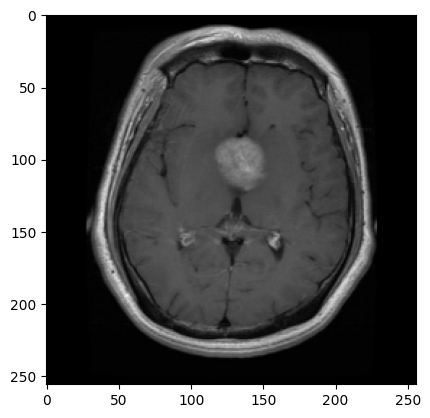

In [9]:
idx = 16
plt.imshow(images[idx])
plt.show()
print(f"Test Set Image Label: {labels[idx]}")

Test Set Image Label: [0. 0. 0. 1.]


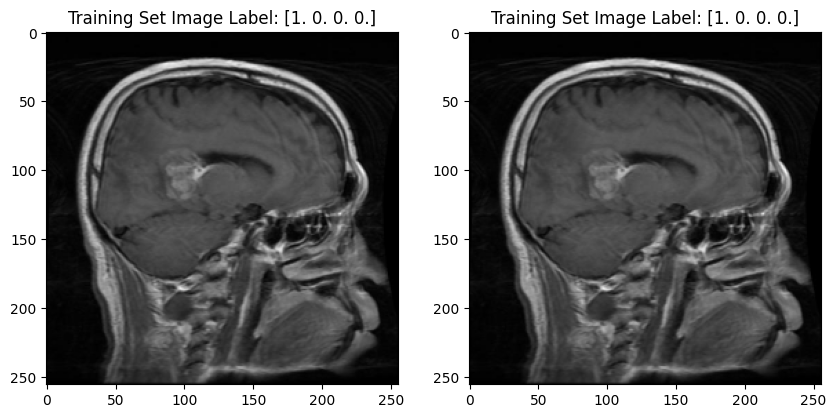

In [10]:
from matplotlib import pyplot as plt
idx = 40
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title(f"Training Set Image Label: {labels[idx]}")
plt.imshow(images[idx])
plt.subplot(1, 2, 2)
plt.title(f"Training Set Image Label: {labels[idx]}")
plt.imshow(images[idx])
plt.show()

# plt.imshow(images[idx]/255.0)
# plt.show()
# print(f"Training Set Image Label: {labels[idx]}")
# print(f"Training Set Image Shape: {images[idx].shape}")

## First Model

In [28]:
first_model = models.Sequential()

first_model.add(layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
first_model.add(layers.Flatten())

first_model.add(layers.Dense(16, activation='relu'))
first_model.add(layers.Dense(4))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
first_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

first_model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 127, 127, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 127008)            0         
                                                                 
 dense_10 (Dense)            (None, 16)                2032144   
                                                                 
 dense_11 (Dense)            (None, 4)                 68        
                                                                 
Total params: 2033108 (7.76 MB)
Trainable params: 2033108 (7.76 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [29]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history=first_model.fit(train_set_normalized, epochs=10, validation_data=val_set_normalized, callbacks=[early_stopping_callback])

Epoch 1/10
36/36 [==============================] - 13s 301ms/step - loss: 2.7922 - accuracy: 0.5094 - val_loss: 0.7510 - val_accuracy: 0.7137
Epoch 2/10
36/36 [==============================] - 12s 298ms/step - loss: 0.5694 - accuracy: 0.7858 - val_loss: 0.5569 - val_accuracy: 0.7863
Epoch 3/10
36/36 [==============================] - 14s 348ms/step - loss: 0.3538 - accuracy: 0.8663 - val_loss: 0.4731 - val_accuracy: 0.8152
Epoch 4/10
36/36 [==============================] - 12s 301ms/step - loss: 0.2370 - accuracy: 0.9133 - val_loss: 0.4507 - val_accuracy: 0.8468
Epoch 5/10
36/36 [==============================] - 12s 301ms/step - loss: 0.1410 - accuracy: 0.9525 - val_loss: 0.5222 - val_accuracy: 0.8336
Epoch 6/10
36/36 [==============================] - 13s 310ms/step - loss: 0.0919 - accuracy: 0.9733 - val_loss: 0.4831 - val_accuracy: 0.8651
Epoch 7/10
36/36 [==============================] - 12s 297ms/step - loss: 0.0590 - accuracy: 0.9847 - val_loss: 0.4186 - val_accuracy: 0.8809

In [13]:
import matplotlib.pyplot as plt


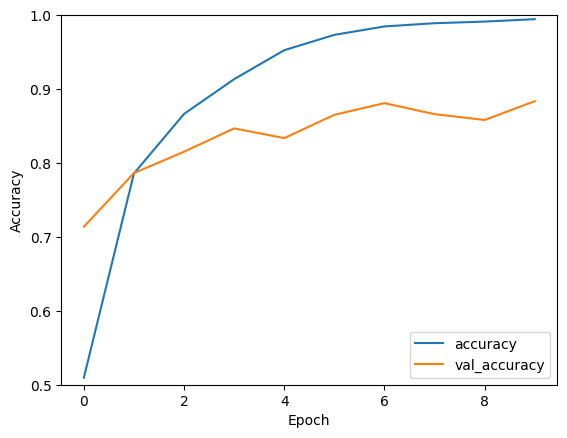

In [30]:
plt.plot(history.history['accuracy'],
         label='accuracy')
plt.plot(history.history['val_accuracy'],
         label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

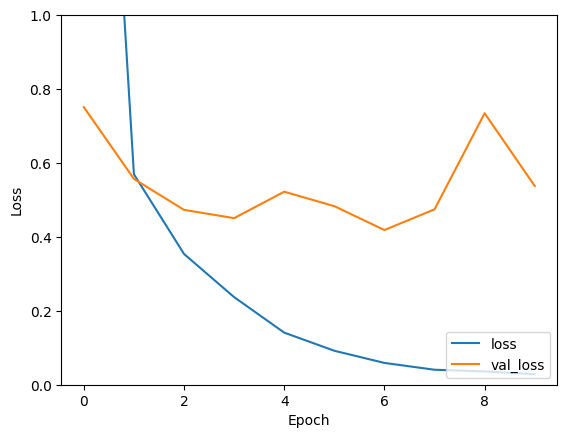

In [31]:
plt.plot(history.history['loss'],
         label='loss')
plt.plot(history.history['val_loss'],
         label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

The model is overfitting. I will have to add a dropout layer, add more convolution layers and more fully connected layers as well as a Maxpooling layer

## Second model

In [36]:
second_model = models.Sequential()

second_model.add(layers.RandomZoom(height_factor=0.1))
second_model.add(layers.RandomRotation(factor=0.2))

second_model.add(layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
second_model.add(layers.MaxPooling2D(pool_size=3, strides=2))

second_model.add(layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu'))
second_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
second_model.add(layers.Flatten())

second_model.add(layers.Flatten())

# Dense layers with dropout
second_model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
second_model.add(layers.Dropout(0.5))

second_model.add(layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
second_model.add(layers.Dropout(0.5))

second_model.add(layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
second_model.add(layers.Dropout(0.5))

# Output layer
second_model.add(layers.Dense(4))

# Compilation and callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
second_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

second_model.build((None, img_size, img_size, 3))

second_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom_3 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_3 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_6 (Conv2D)           (None, 127, 127, 128)     3584      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 31, 31, 256)       295168    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 15, 15, 256)      

In [38]:
history=second_model.fit(train_set_normalized, epochs=10, validation_data=val_set_normalized, callbacks=[early_stopping_callback])

Epoch 1/10
36/36 [==============================] - 14s 342ms/step - loss: 1.1515 - accuracy: 0.6372 - val_loss: 1.0316 - val_accuracy: 0.6821
Epoch 2/10
36/36 [==============================] - 14s 333ms/step - loss: 1.0831 - accuracy: 0.6519 - val_loss: 0.9497 - val_accuracy: 0.7032
Epoch 3/10
36/36 [==============================] - 17s 401ms/step - loss: 1.0501 - accuracy: 0.6613 - val_loss: 0.9505 - val_accuracy: 0.7426
Epoch 4/10
36/36 [==============================] - 13s 336ms/step - loss: 0.9925 - accuracy: 0.6775 - val_loss: 1.1858 - val_accuracy: 0.6112
Epoch 5/10
36/36 [==============================] - 14s 333ms/step - loss: 0.9808 - accuracy: 0.6930 - val_loss: 0.8760 - val_accuracy: 0.7513
Epoch 6/10
36/36 [==============================] - 14s 349ms/step - loss: 0.9373 - accuracy: 0.7077 - val_loss: 0.9493 - val_accuracy: 0.7093
Epoch 7/10
36/36 [==============================] - 13s 338ms/step - loss: 0.9145 - accuracy: 0.7133 - val_loss: 1.1642 - val_accuracy: 0.6095

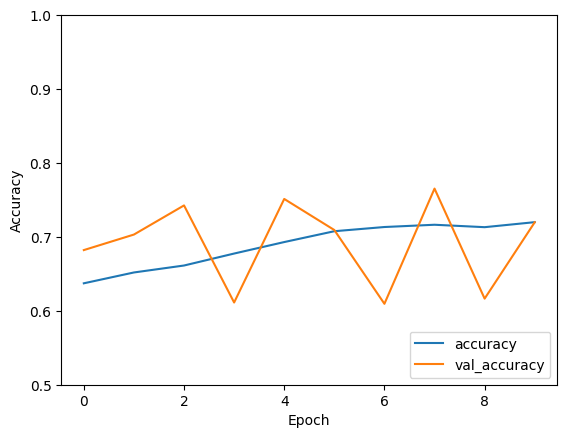

In [39]:
plt.plot(history.history['accuracy'],
         label='accuracy')
plt.plot(history.history['val_accuracy'],
         label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

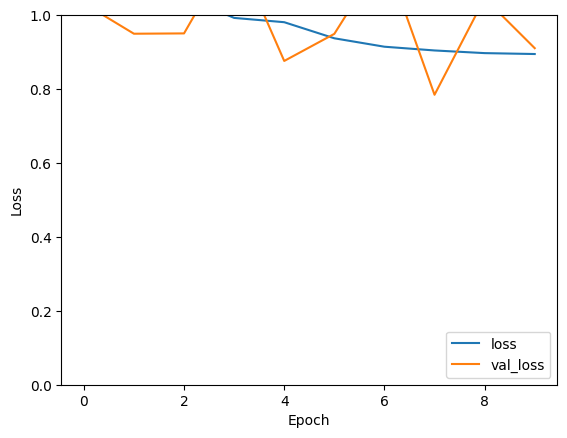

In [40]:
plt.plot(history.history['loss'],
         label='loss')
plt.plot(history.history['val_loss'],
         label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

## ResNet50:

Pros: Utilizes residual blocks which help in training deeper networks, generally performs better on complex datasets, and is known for its excellent performance.
Cons: Can be more complex and computationally intensive compared to VGG16.


### first model

In [18]:
from tensorflow.keras import applications
from tensorflow.keras import layers, Input, Model

In [19]:
# Define the input layer
input_layer = Input(shape=(img_size, img_size, 3))

# Preprocess the input data using ResNet50V2's preprocessing function
preprocessed_input_layer = applications.resnet_v2.preprocess_input(input_layer)

# Add data augmentation layers
augmented_layer = layers.RandomZoom(height_factor=0.1)(preprocessed_input_layer)
augmented_layer = layers.RandomRotation(factor=0.2)(augmented_layer)

# Load the ResNet50V2 model pre-trained on ImageNet, excluding the top layers
base_model = applications.resnet_v2.ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

# Pass the augmented input through the base model
x = base_model(augmented_layer, training=False)

# Add global average pooling
global_pooling = layers.GlobalAveragePooling2D()(x)

# Add custom dense and dropout layers
fc1 = layers.Dense(512)(global_pooling)
fc1 = layers.ReLU()(fc1)

fc2 = layers.Dense(128)(fc1)
fc2 = layers.ReLU()(fc2)

fc3 = layers.Dense(32)(fc2)
fc3 = layers.ReLU()(fc3)

# Output layer for classification
output_layer = layers.Dense(4)(fc3)

s_model = Model(inputs=input_layer, outputs=output_layer)

s_model.summary()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
s_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

s_model.build((None, img_size, img_size, 3))
s_model.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 random_zoom_1 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                     

In [41]:
history=s_model.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[early_stopping_callback])

Epoch 1/10
36/36 [==============================] - 21s 553ms/step - loss: 0.1888 - accuracy: 0.9293 - val_loss: 0.2699 - val_accuracy: 0.9011
Epoch 2/10
36/36 [==============================] - 22s 554ms/step - loss: 0.1595 - accuracy: 0.9400 - val_loss: 0.2955 - val_accuracy: 0.8923
Epoch 3/10
36/36 [==============================] - 22s 584ms/step - loss: 0.1685 - accuracy: 0.9357 - val_loss: 0.2201 - val_accuracy: 0.9256
Epoch 4/10
36/36 [==============================] - 21s 560ms/step - loss: 0.1423 - accuracy: 0.9466 - val_loss: 0.2384 - val_accuracy: 0.9168
Epoch 5/10
36/36 [==============================] - 22s 577ms/step - loss: 0.1479 - accuracy: 0.9438 - val_loss: 0.2125 - val_accuracy: 0.9247
Epoch 6/10
36/36 [==============================] - 22s 583ms/step - loss: 0.1577 - accuracy: 0.9403 - val_loss: 0.2185 - val_accuracy: 0.9256
Epoch 7/10
36/36 [==============================] - 27s 709ms/step - loss: 0.1447 - accuracy: 0.9444 - val_loss: 0.3296 - val_accuracy: 0.8905

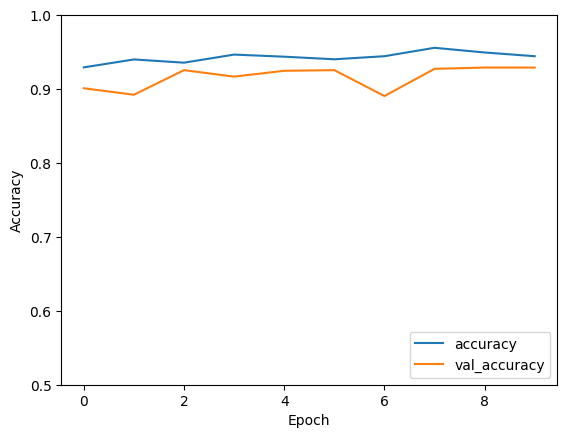

In [42]:
plt.plot(history.history['accuracy'],
         label='accuracy')
plt.plot(history.history['val_accuracy'],
         label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

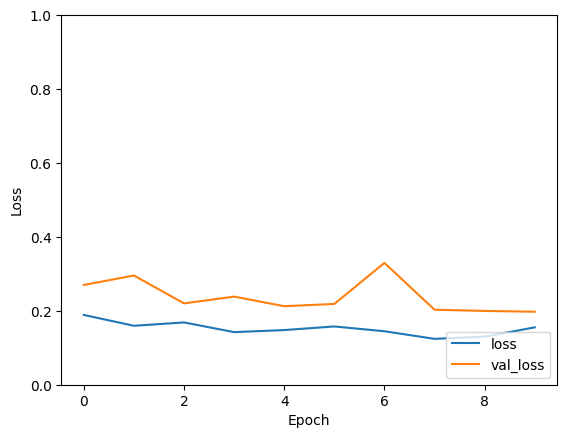

In [43]:
plt.plot(history.history['loss'],
         label='loss')
plt.plot(history.history['val_loss'],
         label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

## model Accuracies

In [44]:
first_model.evaluate(test_set_normalized)

11/11 [==============================] - 2s 101ms/step - loss: 0.3388 - accuracy: 0.8978


[0.3388333022594452, 0.8977879285812378]

In [45]:
second_model.evaluate(test_set_normalized)

11/11 [==============================] - 3s 105ms/step - loss: 1.0139 - accuracy: 0.6789


[1.0139379501342773, 0.6788710951805115]

In [46]:
s_model.evaluate(test_set)

11/11 [==============================] - 6s 386ms/step - loss: 0.2767 - accuracy: 0.9130


[0.27669861912727356, 0.9130434989929199]

## Finally

From the above experiments, we can conclude that the ResNet50 block (Transfer Learning) worked perfectly on the dataset and therefore we achieved over 91% acuracy. With such models in use, we can help the medical industry with real time screening and identification on wether the patients suffer from cancer.